# **AI_Agents_Course Module_2**

[Link of the Course](https:///www.coursera.org/learn/ai-agents-python)

**Instructor: Dr. Jules White**

**Codes Edited by: Houshyar Jafari Asl**

"""
OLLAMA LLM IN COLAB (LOCAL ALTERNATIVE TO OPENAI)

This code sets up a free, local LLM (Llama3) in Google Colab using:
1. Ollama - Runs the model locally
2. LiteLLM - Provides OpenAI-like API interface

HOW IT WORKS:
1. First run: Downloads Llama3 (4.7GB, one-time)
2. Starts Ollama server with CPU
3. Uses LiteLLM to send/receive messages like OpenAI API

ADVANTAGES:
- No API keys needed
- Free to use
- Works offline after setup

NOTE:
- Colab may disconnect after ~1 hour
- Responses slightly slower than GPT-4
"""

# Agent Tools in Python

**AI-Agent Tool Descriptions and Naming**

Describing Tools to the Agent
When developing an agentic AI system, one of the most critical aspects is ensuring that the agent understands the tools it has access to. In our previous tutorial, we explored how an AI agent interacts with an environment. Now, we extend that discussion to focus on tool definition, particularly the importance of naming, parameters, and structured metadata.

**Example: Automating Documentation for Python Code**

Imagine we are building an AI agent that scans through all Python files in a `src/` directory and automatically generates corresponding documentation files in a `docs/` directory. This agent will need to:

* **List Python files** in the `src/` directory.
* **Read the content** of each Python file.
* **Write documentation** files in the `docs/` directory.

Since file operations are straightforward for humans but ambiguous for an AI without context, we must clearly define these tools so the agent knows how to use them effectively.

**Step 1: Defining a Tool with Structured Metadata**

A basic tool definition in Python might look like this:

In [ ]:
def list_python_files():
    """Returns a list of all Python files in the src/ directory."""
    return [f for f in os.listdir("src") if f.endswith(".py")]

This provides a function that retrieves all Python files in the `src/` directory, but for an AI system, we need a more structured way to describe it.

**Step 2: Using JSON Schema to Define Parameters**

When developers design APIs, they use structured documentation to describe available functions, their inputs, and their outputs. JSON Schema is a well-known format for defining APIs, making it a natural choice for AI agents as well.

For example, a tool that reads a file should specify that it expects a `file_path` parameter of type `string`. JSON Schema allows us to express this in a standardized way:

In [ ]:
{
  "tool_name": "read_file",
  "description": "Reads the content of a specified file.",
  "parameters": {
    "type": "object",
    "properties": {
      "file_path": { "type": "string" }
    },
    "required": ["file_path"]
  }
}

Similarly, a tool for writing documentation should define that it requires a `file_name` and `content`:

In [ ]:
{
  "tool_name": "write_doc_file",
  "description": "Writes a documentation file to the docs/ directory.",
  "parameters": {
    "type": "object",
    "properties": {
      "file_name": { "type": "string" },
      "content": { "type": "string" }
    },
    "required": ["file_name", "content"]
  }
}

By providing a JSON Schema for each tool:

1. **The AI can Recognize the tool’s purpose.**

2. **The AI / Environment interface can validate input parameters before execution.**

It may look strange that multiple parameters to a function are represented as an object. When we are getting the agent to output a tool / action selection, we are going to want it to output something like this:

In [ ]:
{
  "tool_name": "read_file",
  "args": {
    "file_path": "src/file.py"
  }
}

The schema describes the overall dictionary that will be used to capture the “args” to the function, so it is described as an object.

# Try Out an Agent that Calls Python Functions

**Try out this agent that can call Python functions.**

When you run the notebook, the agent will prompt you for what action to take. You can say something like "tell me the files in the current directory" and it will make the appropriate tool choice. Experiment with the agent to see what it can and cannot do.

Look for an input beneath the  code block to type your command into and hit enter. Remember, this agent can only list the files in the directory and read files.

In [13]:
!pip install -q litellm requests
!curl -fsSL https://ollama.com/install.sh | sh
!pkill -9 ollama || true
!OLLAMA_CUDA_OVERRIDE="1" nohup ollama serve > server.log 2>&1 &
!OLLAMA_CUDA_OVERRIDE="1" ollama pull llama3

import time, json, os, sys, re, requests
from litellm import completion
from typing import List, Dict

time.sleep(25)

def extract_markdown_block(response: str, block_type: str = "json") -> str:
    if not '```' in response:
        return response
    code_block = response.split('```')[1].strip()
    if code_block.startswith(block_type):
        code_block = code_block[len(block_type):].strip()
    return code_block

def generate_response(messages: List[Dict]) -> str:
    response = completion(
        model="ollama/llama3",
        messages=messages,
        max_tokens=1024,
        api_base="http://localhost:11434"
    )
    return response.choices[0].message.content.strip()

def parse_action(response: str) -> Dict:
    try:
        response = extract_markdown_block(response, "action")
        response_json = json.loads(response)
        if "tool_name" in response_json and "args" in response_json:
            return response_json
        else:
            return {"tool_name": "error", "args": {"message": "You must respond with a JSON tool invocation."}}
    except json.JSONDecodeError:
        return {"tool_name": "error", "args": {"message": "Invalid JSON response. You must respond with a JSON tool invocation."}}

def list_files() -> List[str]:
    return os.listdir(".")

def read_file(file_name: str) -> str:
    try:
        with open(file_name, "r") as file:
            return file.read()
    except Exception as e:
        return f"Error: {str(e)}"

agent_rules = [{
    "role": "system",
    "content": """
You are an AI agent that can perform tasks by using available tools.

Available tools:

\\```json
{
    "list_files": {
        "description": "Lists all files in the current directory.",
        "parameters": {}
    },
    "read_file": {
        "description": "Reads the content of a file.",
        "parameters": {
            "file_name": {
                "type": "string",
                "description": "The name of the file to read."
            }
        }
    },
    "terminate": {
        "description": "Ends the agent loop and provides a summary of the task.",
        "parameters": {
            "message": {
                "type": "string",
                "description": "Summary message to return to the user."
            }
        }
    }
}
\\```

Every response MUST be an action block:

\\```action
{
    "tool_name": "insert tool_name",
    "args": {...}
}
\\```
"""
}]

# 🔧 Replace this with user input for production use
user_task = "List the files in this directory."
print(f"\nUser asked: {user_task}")

memory = [{"role": "user", "content": user_task}]
iterations = 0
max_iterations = 5

while iterations < max_iterations:
    prompt = agent_rules + memory
    print("\nAgent thinking...")
    response = generate_response(prompt)
    print(f"\nAgent response:\n{response}")

    action = parse_action(response)

    if action["tool_name"] == "list_files":
        result = {"result": list_files()}
    elif action["tool_name"] == "read_file":
        result = {"result": read_file(action["args"]["file_name"])}
    elif action["tool_name"] == "terminate":
        print("\nAgent terminated:", action["args"]["message"])
        break
    elif action["tool_name"] == "error":
        result = {"error": action["args"]["message"]}
    else:
        result = {"error": f"Unknown tool: {action['tool_name']}"}

    print(f"\nAction result: {result}")

    memory.extend([
        {"role": "assistant", "content": response},
        {"role": "user", "content": json.dumps(result)}
    ])

    if action["tool_name"] == "terminate":
        break

    iterations += 1


>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


User asked: List the files in this directory.

Agent thinking...

Agent response:
```
{
  "tool_name": "list_files",
  "args": {}
}
```

Action result: {'result': ['.config', 'server.log', 'sample_data']}

Agent thinking...

Agent response:
```
{
  "tool_name": "terminate",
  "args": {
    "message": "Task completed: Listed files in the current directory. The files are .config, server.log, and sample_data."
  }
}
```

Agent terminated: Task completed: Listed files in the current directory. The files are .config, server.log, and sample_data.


# Using LLM Function Calling for AI-Agent Interaction

**Step 3: Using LLM Function Calling for Structured Execution**

One of the most challenging aspects of integrating AI agents with tool execution is ensuring that the model consistently produces structured output that can be parsed correctly. Traditionally, developers would attempt to engineer prompts to make the model output well-formed JSON, but this approach is unreliable—models can introduce variations, omit required fields, or output unstructured text that breaks parsing logic.

To solve this, most LLMs offer **function calling** APIs that guarantee structured execution. Instead of treating function execution as a free-form text generation task, function calling APIs allow us to explicitly define the tools available to the model using **JSON Schema**. The model then decides when and how to call these functions, ensuring structured and predictable responses.

**How Function Calling Simplifies AI-Agent Interfaces**

When using function calling, the model returns either:

1. **A function call** that includes the tool name and arguments as structured JSON.
2. **A standard text response** if the model decides a function is unnecessary.

This approach removes the need for manual prompt engineering to enforce structured output and allows the agent to focus on decision-making rather than syntax compliance.

**Example: Executing Function Calls**

Below is a typical way to invoke function calling using OpenAI’s API:

In [ ]:
import json
import os
from typing import List

from litellm import completion

def list_files() -> List[str]:
    """List files in the current directory."""
    return os.listdir(".")

def read_file(file_name: str) -> str:
    """Read a file's contents."""
    try:
        with open(file_name, "r") as file:
            return file.read()
    except FileNotFoundError:
        return f"Error: {file_name} not found."
    except Exception as e:
        return f"Error: {str(e)}"


tool_functions = {
    "list_files": list_files,
    "read_file": read_file
}

tools = [
    {
        "type": "function",
        "function": {
            "name": "list_files",
            "description": "Returns a list of files in the directory.",
            "parameters": {"type": "object", "properties": {}, "required": []}
        }
    },
    {
        "type": "function",
        "function": {
            "name": "read_file",
            "description": "Reads the content of a specified file in the directory.",
            "parameters": {
                "type": "object",
                "properties": {"file_name": {"type": "string"}},
                "required": ["file_name"]
            }
        }
    }
]

# Our rules are simplified since we don't have to worry about getting a specific output format
agent_rules = [{
    "role": "system",
    "content": """
You are an AI agent that can perform tasks by using available tools.

If a user asks about files, documents, or content, first list the files before reading them.
"""
}]

user_task = input("What would you like me to do? ")

memory = [{"role": "user", "content": user_task}]

messages = agent_rules + memory

response = completion(
    model="openai/gpt-4o",
    messages=messages,
    tools=tools,
    max_tokens=1024
)

# Extract the tool call from the response, note we don't have to parse now!
tool = response.choices[0].message.tool_calls[0]
tool_name = tool.function.name
tool_args = json.loads(tool.function.arguments)
result = tool_functions[tool_name](**tool_args)

print(f"Tool Name: {tool_name}")
print(f"Tool Arguments: {tool_args}")
print(f"Result: {result}")

**Breaking Down Function Calling Step by Step**

Let’s examine how function calling works in detail:

1. **Define the Tool Functions**

In [ ]:
def list_files() -> List[str]:
    """List files in the current directory."""
    return os.listdir(".")

def read_file(file_name: str) -> str:
    """Read a file's contents."""
    try:
        with open(file_name, "r") as file:
            return file.read()
    except FileNotFoundError:
        return f"Error: {file_name} not found."
    except Exception as e:
        return f"Error: {str(e)}"

First, we define the actual Python functions that will be executed. These contain the business logic for each tool and handle the actual operations the AI agent can perform.

2. **Create a Function Registry**

In [ ]:
tool_functions = {
    "list_files": list_files,
    "read_file": read_file
}

We maintain a dictionary that maps function names to their corresponding Python implementations. This registry allows us to easily look up and execute the appropriate function when the model calls it.

3. **Define Tool Specifications Using JSON Schema**

In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "list_files",
            "description": "Returns a list of files in the directory.",
            "parameters": {"type": "object", "properties": {}, "required": []}
        }
    },
    {
        "type": "function",
        "function": {
            "name": "read_file",
            "description": "Reads the content of a specified file in the directory.",
            "parameters": {
                "type": "object",
                "properties": {"file_name": {"type": "string"}},
                "required": ["file_name"]
            }
        }
    }
]

This is where we describe our tools to the model. Each tool specification includes:

* A **name** that matches a key in our tool_functions dictionary
* A **description** that helps the model understand when to use this tool
* **Parameters** defined using JSON Schema, specifying the expected input format

Note how the `list_files` function takes no parameters (empty “properties” object), while `read_file` requires a “file_name” string parameter. The model will use these specifications to generate properly structured calls.

**4. Set Up the Agent’s Instructions**

In [ ]:
agent_rules = [{
    "role": "system",
    "content": """
You are an AI agent that can perform tasks by using available tools.

If a user asks about files, documents, or content, first list the files before reading them.
"""
}]

The system message provides guidance on how the agent should behave. With function calling, we don’t need to instruct the model on how to format its outputs - we only need to focus on the decision-making logic.

5. **Prepare the Conversation Context**

In [ ]:
user_task = input("What would you like me to do? ")
memory = [{"role": "user", "content": user_task}]
messages = agent_rules + memory

We combine the system instructions with the user’s input to create the conversation context.

6. **Make the API Call with Function Definitions**

In [ ]:
response = completion(
    model="openai/gpt-4o",
    messages=messages,
    tools=tools,
    max_tokens=1024
)

The critical difference here is the inclusion of the tools parameter, which tells the model what functions it can call. This is what activates the function calling mechanism.

7. **Process the Structured Response**

In [ ]:
tool = response.choices[0].message.tool_calls[0]
tool_name = tool.function.name
tool_args = json.loads(tool.function.arguments)

When using function calling, the response comes back with a dedicated `tool_calls` array rather than free-text output. This ensures that:

* The **function name** is properly identified
* The **arguments** are correctly formatted as valid JSON
* We don’t need to parse or extract from unstructured text

8. **Execute the Function with the Provided Arguments**

In [ ]:
result = tool_functions[tool_name](**tool_args)

Finally, we look up the appropriate function in our registry and call it with the arguments the model provided. The `**tool_args` syntax unpacks the JSON object into keyword arguments.

**Key Benefits of Function Calling APIs**

1. **Eliminates prompt engineering for structured responses** – No need to force the model to output JSON manually.

2. **Uses standardized JSON Schema** – The same format used in API documentation applies seamlessly to AI interactions.
3. **Allows mixed text and tool execution** – The model can decide whether a tool is necessary or provide a natural response.
4. **Simplifies parsing logic** – Instead of handling inconsistent outputs, developers only check for tool_calls in the response.
5. **Guarantees syntactically correct arguments** – The model automatically ensures arguments match the expected parameter format.

**Conclusion**

Function calling APIs significantly improve the reliability of AI-agent interactions by enforcing structured execution. By defining tools with JSON Schema and letting the model determine when to use them, we build a more predictable and maintainable AI environment interface. In the next section, we will explore **how to register these tools dynamically using decorators** to further streamline agent development.

# Simplifying the AI Agent Loop with Function Calling

**Function Calling and the Simplified Agent Loop**

Now that we have explored function calling, we can significantly simplify our AI agent loop. Traditionally, parsing the LLM’s responses required engineering strict output formats, validating them, and handling errors when the model deviated from the expected structure. With function calling, the model now natively supports structured responses, ensuring we receive either a valid function call or a standard text reply.

This dramatically reduces the complexity of parsing responses and handling actions. Instead of manually extracting commands from unstructured text, we can directly interpret the function calls provided by the model and execute them with confidence.

**How Function Calling Simplifies the Agent Loop**

Let’s revisit the agent loop, but now using function calling. Instead of handling multiple layers of parsing, we let the model’s API return structured function calls when needed.

In [ ]:
import json
import os
from typing import List

from litellm import completion

def list_files() -> List[str]:
    """List files in the current directory."""
    return os.listdir(".")

def read_file(file_name: str) -> str:
    """Read a file's contents."""
    try:
        with open(file_name, "r") as file:
            return file.read()
    except FileNotFoundError:
        return f"Error: {file_name} not found."
    except Exception as e:
        return f"Error: {str(e)}"

def terminate(message: str) -> None:
    """Terminate the agent loop and provide a summary message."""
    print(f"Termination message: {message}")

tool_functions = {
    "list_files": list_files,
    "read_file": read_file,
    "terminate": terminate
}

tools = [
    {
        "type": "function",
        "function": {
            "name": "list_files",
            "description": "Returns a list of files in the directory.",
            "parameters": {"type": "object", "properties": {}, "required": []}
        }
    },
    {
        "type": "function",
        "function": {
            "name": "read_file",
            "description": "Reads the content of a specified file in the directory.",
            "parameters": {
                "type": "object",
                "properties": {"file_name": {"type": "string"}},
                "required": ["file_name"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "terminate",
            "description": "Terminates the conversation. No further actions or interactions are possible after this. Prints the provided message for the user.",
            "parameters": {
                "type": "object",
                "properties": {
                    "message": {"type": "string"},
                },
                "required": ["message"]
            }
        }
    }
]

agent_rules = [{
    "role": "system",
    "content": """
You are an AI agent that can perform tasks by using available tools.

If a user asks about files, documents, or content, first list the files before reading them.

When you are done, terminate the conversation by using the "terminate" tool and I will provide the results to the user.
"""
}]

# Initialize agent parameters
iterations = 0
max_iterations = 10

user_task = input("What would you like me to do? ")

memory = [{"role": "user", "content": user_task}]

# The Agent Loop
while iterations < max_iterations:

    messages = agent_rules + memory

    response = completion(
        model="openai/gpt-4o",
        messages=messages,
        tools=tools,
        max_tokens=1024
    )

    if response.choices[0].message.tool_calls:
        tool = response.choices[0].message.tool_calls[0]
        tool_name = tool.function.name
        tool_args = json.loads(tool.function.arguments)

        action = {
            "tool_name": tool_name,
            "args": tool_args
        }

        if tool_name == "terminate":
            print(f"Termination message: {tool_args['message']}")
            break
        elif tool_name in tool_functions:
            try:
                result = {"result": tool_functions[tool_name](**tool_args)}
            except Exception as e:
                result = {"error":f"Error executing {tool_name}: {str(e)}"}
        else:
            result = {"error": f"Unknown tool: {tool_name}"}

        print(f"Executing: {tool_name} with args {tool_args}")
        print(f"Result: {result}")
        memory.extend([
            {"role": "assistant", "content": json.dumps(action)},
            {"role": "user", "content": json.dumps(result)}
        ])
    else:
        result = response.choices[0].message.content
        print(f"Response: {result}")
        break

**What This Changes**

1. **No More Custom Parsing Logic** - We don’t need to engineer strict text output parsing; the model always returns structured JSON for function calls.
2. **Dynamic Execution** - Instead of a rigid loop that manually checks what the agent should do, we simply read and execute the function call.
3. **Unified Text & Action Handling** - If no function call is needed, the model responds with a message, allowing mixed conversational and action-driven workflows.
4. **Automated Function Execution** - The agent dynamically maps the tool name from the model to its corresponding Python function and executes it with the provided arguments.

**Errors Can Still Occur**

While function calling improves structured execution, it does not eliminate all potential issues. One common problem is that the model may still sometimes return improperly formatted JSON or a tool call that isn’t valid. For example, the response could contain syntax errors, missing required fields, or incorrectly formatted values. If the agent attempts to parse this malformed JSON, it will fail.

To address this, we could add error handling around `json.loads()` to catch `json.JSONDecodeError`. If a parsing error occurs, the agent retries by sending another request. This prevents the entire loop from crashing and ensures robustness in execution. You can do this as a practice exercise to enhance the agent’s reliability.

Additionally, even when the JSON is correctly formatted, errors can still arise at runtime due to missing files, incorrect arguments, or unexpected edge cases in function execution. Our error handling ensures that these issues do not halt execution entirely but instead provide meaningful feedback for debugging and improvement.

**Key Takeaways**

By leveraging function calling, we remove unnecessary complexity from the agent loop, allowing the AI to interact with its environment more reliably. This simplification makes AI agents more robust, scalable, and easier to integrate into real-world applications.

In a later lesson, we will explore **how to register tools dynamically with decorators**, further improving flexibility and maintainability in AI agent design.

# Tool Design and Naming Best Practices for AI Agents

**Designing Effective Tools for AI Agents**

When designing tools for an AI agent, the goal is to provide a **limited, well-defined set of functions** that are as specific as possible to the agent’s intended task. Well-designed tools reduce ambiguity, improve reliability, and help the AI execute actions correctly without misinterpretation.

**Why Tool Design Matters**

Sometimes, if tools are too generic, such as a single `list_files` or `read_file` function, the AI might struggle to use them correctly. For instance, an agent might attempt to read a file but specify the wrong directory, leading to errors. Instead, tools should be structured to enforce correctness while minimizing the agent’s margin for error.

Agents can use generic tools as well, but more specialized tools are easier to manage and less prone to misuse by the agent. There is a trade-off between the specificity of tools and the flexibility they provide. More specific tools also limit reuse, so finding the right balance is crucial. When building an agent inititally, err on the side of specificity.

Let’s assume that rather than a generic file agent, we are writing an agent that works with Python code and documentation. Instead of defining broad functions like:

Let’s assume that rather than a generic file agent, we are writing an agent that works with Python code and documentation. Instead of defining broad functions like:

* `list_files(directory: str)` → Returns all files in a specified directory.
* `read_file(file_path: str)` → Reads a file from an arbitrary path.
* `write_file(file_path: str, content: str)` → Writes to an arbitrary file.

We should define **task-specific functions** like:

* `list_python_files()` → Returns Python files **only** from the src/ directory.
* `read_python_file(file_name: str)` → Reads a Python file **only** from the src/ directory.
* `write_documentation(file_name: str, content: str)` → Writes documentation **only** to the docs/ directory.

In the context of the more limited scope of Python documentation, the constraints reduce the chances of incorrect agent behavior while making it clear what each tool does.

**Example: Reading a Python File**

In [ ]:
{
  "tool_name": "read_python_file",
  "description": "Reads the content of a Python file from the src/ directory.",
  "parameters": {
    "type": "object",
    "properties": {
      "file_name": { "type": "string" }
    },
    "required": ["file_name"]
  }
}

**Example: Writing Documentation**

In [ ]:
{
  "tool_name": "write_documentation",
  "description": "Writes a documentation file to the docs/ directory.",
  "parameters": {
    "type": "object",
    "properties": {
      "file_name": { "type": "string" },
      "content": { "type": "string" }
    },
    "required": ["file_name", "content"]
  }
}

**Step 2: Naming Matters – Best Practices for Tool Naming**

Naming plays a crucial role in AI comprehension. If we name a tool `proc_handler`, the AI might struggle to infer its purpose. Instead, naming it `process_file` provides better clarity.

**Example: Naming Comparison**

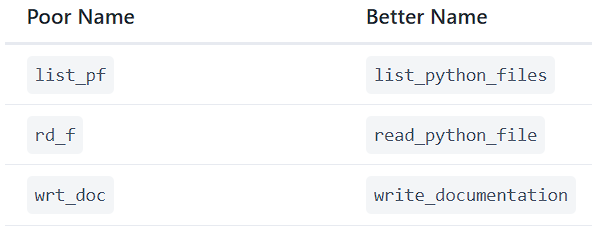

Even with well-named tools, we still need structured descriptions for disambiguation, especially in specialized domains.

**Step 3: Robust Error Handling in Tools**

Each tool should be designed to handle errors gracefully and provide **rich error messages** back to the agent. This helps prevent failures and enables the agent to adjust its actions dynamically when unexpected issues occur.

**Example: Improving `read_python_file` with Error Handling**

In [ ]:
import os

def read_python_file(file_name):
    """Reads a Python file from the src/ directory with error handling."""
    file_path = os.path.join("src", file_name)

    if not file_name.endswith(".py"):
        return {"error": "Invalid file type. Only Python files can be read."}

    if not os.path.exists(file_path):
        return {"error": f"File '{file_name}' does not exist in the src/ directory."}

    with open(file_path, "r") as f:
        return {"content": f.read()}

This version ensures:

* **Only Python files are read.**
* **Non-existent files return an informative error.**
* **All responses are structured for easy agent parsing.**

**Instructions in Error Messages**

When we know that certain tools will always be used together or that there is a right way to handle a particular error, we can provide that information back to the agent in the error message. For example, in our `read_python_file` function, if the file does not exist, we can suggest that the agent call the `list_python_files` function to get an accurate list of file names.

In [ ]:
def read_python_file(file_name):
    """Reads a Python file from the src/ directory with error handling."""
    file_path = os.path.join("src", file_name)

    if not file_name.endswith(".py"):
        return {"error": "Invalid file type. Only Python files can be read. Call the list_python_files function to get a list of valid files."}
  ...

We could put this information into the original agent rules, but then the agent would have to remember it. Further, adding it there creates a more complicated set of rules for the agent to remember and may have unexpected side effects on how it handles errors in other tools. By injecting the instruction here, we can ensure that the agent has the information it needs to handle this error without having to remember it in its rules. It also gets the instruction “just in time” when it needs it.

**Conclusion**

When integrating AI into real-world environments, tool descriptions must be **explicit, structured, and informative**. By following these principles:

* **Use descriptive names.**
* **Provide structured metadata.**
* **Leverage JSON Schema for parameters.**
* **Ensure AI has contextual understanding.**
* **Include robust error handling.**
* **Provide informative error messages.**
* **Inject instructions into error messages.**

This approach ensures that AI agents can interact with their environments effectively while minimizing incorrect or ambiguous tool usage. In the next tutorial, we will explore **dynamic tool registration using decorators**, further improving flexibility and maintainability in AI agent design.